# PS4 - K-Means Clustering

## 1. What are the top 3 most common coffee places?

In [1]:
import folium
# from folium import plugins

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
coffee = pd.read_csv('coffeeshops.csv')
coffee.drop('id', axis=1, inplace=True)
coffee.head(5)

,name,lat,lng,checkins,address
0,Starbucks Coffee,14.734710,121.057599,10428,"Ground Flr, SM City Fairview (Annex 1)"
1,Starbucks Coffee,14.735735,121.060213,3793,"Fairview Terraces, Quirino Hwy"
2,The Coffee Bean & Tea Leaf,14.736308,121.058135,17441,"G/F Gateway Mall, Gen Roxas Ave"
3,Starbucks Coffee,14.734639,121.059474,4116,"2nd Flr, SM City Fairview (Main Bldg)"
4,Starbucks Coffee,14.553593,121.050662,40149,"Crossroads, Bonifacio Global City"


In [3]:
coffee.drop_duplicates(inplace=True)

In [4]:
coffee.name.value_counts().head(3)

Starbucks Coffee              151
The Coffee Bean & Tea Leaf     31
Seattle's Best Coffee          15
Name: name, dtype: int64

The top 3 most common coffee places are: **Starbucks Coffee**, **The Coffee Bean & Tea Leaf**, and **Seattle's Best Coffee**.

## 2. What is the latitude variance and longitude variance, and explain why these variances are different?

In [5]:
print('Latitude variance: {lat}\nLongitude variance: {lng}'.format(lat=round(np.var(coffee.lat),5), lng=round(np.var(coffee.lng),5)))

Latitude variance: 0.00708
Longitude variance: 0.00155


There is more variance in the latitude than in the longitude. This means that the coffeeshops are spread in a wider range of latitudinal coordinate. This is shown in the map below. Also, the Philippines geographically covers more latitude than longitude.

In [6]:
map1 = folium.Map(location=[np.mean(coffee.lat), np.mean(coffee.lng)], height=1000, width=1000, tiles="OpenStreetMap", zoom_start=10)

for index, row in coffee.iterrows():
    folium.CircleMarker(
    location=[row['lat'], row['lng']],
    radius=6,
    popup=row['address'],
    tooltip=row['name'],
    color='#428bca',
    fill=True,
    fill_color='#428bca',
    alpha=0.8
    ).add_to(map1)

map1

## 3. Explain what KMeans inertia is and how different it is from DBSCAN epsilon.

**K-means inertia** is the summation of the square of the distances between each data points and its centroid. Inertia decreases as the number of clusters increase. The optimum number of clusters is found where both inertia and number of clusters are low.

On the other hand, **DBSCAN epsilon** is distance extended from a data point. Data points within this range are considered neighbors and part of a cluster if the number of points found is equal or greater than the `min_samples` parameter.

## 4. Cluster the locations data with DBSCAN.

Import DBSCAN for the ckustering algorithm and NearestNeighbors for the optimization of parameter epsilon.

In [7]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

### Find Epsilon

This optimization technique calculates the average distance between each point and its k nearest neighbors, where k = the `min_samples` value you selected. The average k-distances are then plotted in ascending order on a k-distance graph. You’ll find the optimal value for ε at the point of maximum curvature.

In [8]:
neigh = NearestNeighbors(n_neighbors=5)
nbrs = neigh.fit(coffee[['lat','lng']])
distances, indices = nbrs.kneighbors(coffee[['lat','lng']])

In [9]:
distances = np.sort(distances, axis=0)
distances = distances[:,1]

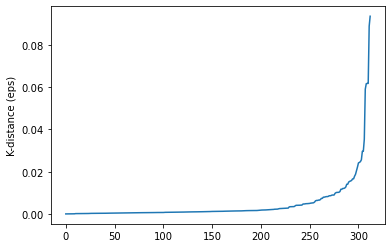

In [10]:
plt.plot(distances)

plt.ylabel("K-distance (eps)")

plt.show()

#### Zoom in on the curvature

The point of maximum curvature is around **K-distance = 0.005**.

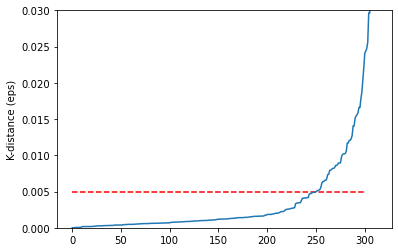

In [11]:
plt.plot(distances)
plt.ylim(0,0.03)
plt.ylabel("K-distance (eps)")
plt.hlines(y=0.005,xmin=0,xmax=300,color='r',linestyles='--')
plt.show()

### Find the clusters

Write a helper function to plot and color the clusters.

In [12]:
def display_clusters(model,data):
    labels = model.fit_predict(data)
    sns.scatterplot(data=data,x='lng',y='lat',hue=labels,palette='Set1',)

<AxesSubplot:xlabel='lng', ylabel='lat'>

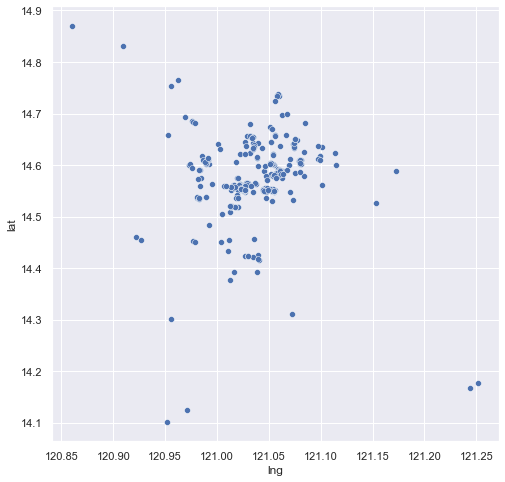

In [13]:
sns.set(rc = {'figure.figsize':(8,8)})
sns.scatterplot(data=coffee, x='lng', y='lat')

Plot and color the clusters.

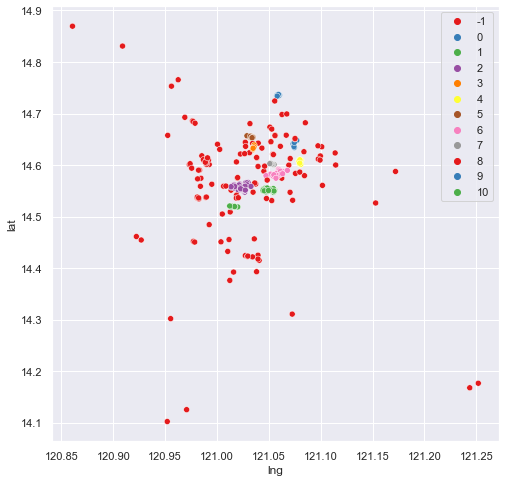

In [14]:
dbscan = DBSCAN(eps=0.005, min_samples=5) # using the optimal epsilon value
display_clusters(dbscan,coffee[['lat','lng']])

In [15]:
# create a column containing information about the cluster assignment of each coffee shops
coffee['cluster'] = dbscan.labels_ 

In [16]:
# assign color to each cluster
color_value = {
    -1:'aquamarine3',
    0:'blue',
    1:'green',
    2:'yellow',
    3:'royalblue',
    4:'maroon',
    5:'forestgreen',
    6:'mediumorchid',
    7:'blueviolet',
    8:'deeppink',
    9:'olive',
    10:'goldenrod',
    11:'lightcyan',
    12:'navy'
}

In [17]:
# create color column
coffee['color'] = list(map(lambda x: color_value.get(x) if x in color_value else x, coffee.cluster))

In [18]:
coffee.sample(5)

,name,lat,lng,checkins,address,cluster,color
21,Starbucks Coffee,14.562810,120.995012,16426,"G/F Torre Lorenzo Plaza, Pablo Ocampo Sr Ave",-1,aquamarine3
3723,Mrs. Fields Cafe,14.520622,121.012251,4299,Ninoy Aquino International Airport - Terminal 3,10,goldenrod
43,Starbucks Coffee,14.484417,120.992474,9475,"Ground Flr, SM City Sucat",-1,aquamarine3
2716,Starbucks Coffee,14.557312,121.019855,4768,"G/F Security Bank Centre, Ayala Ave",2,yellow
2296,Seattle's Best Coffee,14.597991,121.045926,1901,"Cardinal Santos Medical Center, Wilson St.",-1,aquamarine3


### Map the clusters

In [19]:
map2 = folium.Map(location=[np.mean(coffee.lat), np.mean(coffee.lng)], height=1000, width=1000, tiles="OpenStreetMap", zoom_start=10)

for index, row in coffee.iterrows():
    folium.CircleMarker(
    location=[row['lat'], row['lng']],
    radius=6,
    popup=row['name'],
    tooltip=row['cluster'],
    color=row['color'],
    fill=True,
    fill_color=row['color'],
    alpha=0.7
    ).add_to(map2)

map2

## 5. Present an analysis of the data following the DBSCAN results.

- Explain what the clusters mean
- What does the number of clusters tell us?
- What is this information useful for?
____

The algorithm detected outliers and identified 11 clusters listed below:

- Cluster 0: Around SM Fairview
- Cluster 1: BGC
- Cluster 2: Makati Ayala
- Cluster 3: Tomas Morato Avenue
- Cluster 4: Eastwood
- Cluster 5: North Edsa
- Cluster 6: Ortigas
- Cluster 7: Greenhills
- Cluster 8: University Belt, Manila
- Cluster 9: Ateneo de Manila area
- Cluster 10: NAIA

These clusters are areas densely populated with coffee shops.

In [20]:
cluster_value = {
    -1: 'Outlier',
    0: 'Around SM Fairview',
    1: 'BGC',
    2: 'Makati Ayala',
    3: 'Tomas Morato Avenue',
    4: 'Eastwood',
    5: 'North Edsa',
    6: 'Ortigas',
    7: 'Greenhills',
    8: 'University Belt, Manila',
    9: 'Ateneo de Manila area',
    10: 'NAIA'
}

coffee['area'] = list(map(lambda x: cluster_value.get(x) if x in cluster_value else x, coffee.cluster))

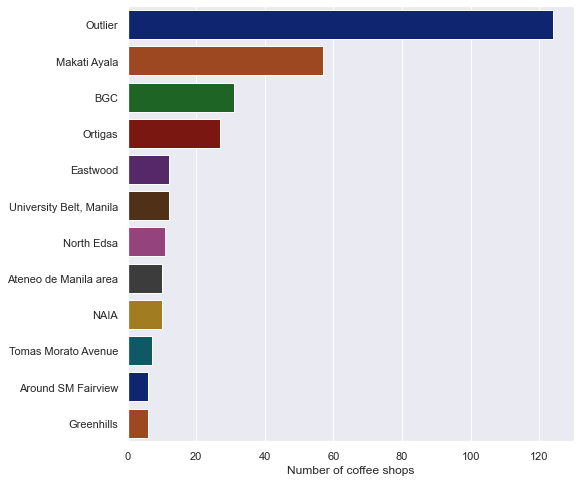

In [21]:
sns.set_theme(style="darkgrid")
sns.countplot(data=coffee, y='area', palette="dark", order=coffee['area'].value_counts().index)
plt.ylabel('')
plt.xlabel('Number of coffee shops')
plt.show()

The graph above shows the cluster locations and its corresponding number of coffee shops. 
- The majority of the coffee shops are outliers and are located outside of the clusters. 
- Makati Ayala is the most densely populated area with coffee shops. 
- The clusters are located mainly on major cities and on places near major universities.
_____

## Bonus 1. What is your favorite coffee shop?

Answer: **Starbucks**

## Bonus 2. Run everything on your own geospatial dataset, and answer the same questions listed above. (5pts) Use this: https://developer.foursquare.com/docs/resources/categories

Answer: **The link given is not working.**